<a href="https://colab.research.google.com/github/viniciusvmda/procedural-texture/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação Genética
https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

## Requisitos

In [0]:
# GP
!pip install deap
# Graphics
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx
# Noise functions
!pip install noise
# Pattern generation
!pip install imagen

## Bibliotecas

In [0]:
# Genetic Programming
from deap import base, creator, gp, tools, algorithms

# Graphics
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt

# Computer vision
import cv2
from google.colab.patches import cv2_imshow

# Util
import numpy as np
import random
import math
import operator   # math basic operations
import time
import multiprocessing
from copy import deepcopy
import warnings
import sys

# Operators
from noise import snoise2
import imagen as ig   # Pattern generation
from skimage.measure import compare_ssim
from sklearn.cluster import KMeans   # get dominant colors

# Upload images
from google.colab import files
from io import BytesIO


## Desenvolvimento

### Constantes

In [0]:
# Image constants
NUMBER_OF_CHANNELS = 3
RGB_MAX = 255;

# Operators
MAX_OCTAVES = 5   # perlin noise
MAX_NUMBER_OF_TILES = 10
MAX_NUMBER_OF_LINES = 10   # chessboard
N_DOMINANT_COLORS = 3
IMG_SIZE_TO_COMPARE_COLORS = 10
IMG_SIZE_TO_COMPARE_IMAGES = 100
MARGIN_OF_ERROR = 30
MAX_WEIGHT_ON_IMG_ADD = 10   # addWeighted

tiles = ig.SquareGrating()

### Util

In [0]:
def plotTree(expr):
  nodes, edges, labels = gp.graph(expr)
  
  g = nx.DiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")

  nx.draw_networkx_nodes(g, pos)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels)
  
  plt.show()

  
def convertFloatToUint8(img):
  return cv2.normalize(img, None, RGB_MAX, 0, cv2.NORM_MINMAX, cv2.CV_8UC3);


def createHistogram(cluster):
  numLabels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
  hist, _ = np.histogram(cluster.labels_, bins=numLabels)
  hist = hist.astype('float32')
  hist /= hist.sum()
  return hist
  

def getDominantColorsKmeans(img):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    imgResized = cv2.resize(img, (IMG_SIZE_TO_COMPARE_COLORS, IMG_SIZE_TO_COMPARE_COLORS))
    imgReshaped = imgResized.reshape((imgResized.shape[0] * imgResized.shape[1], imgResized.shape[2]))

    clusters = KMeans(n_clusters=N_DOMINANT_COLORS).fit(imgReshaped)
    # count the dominant colors and put them in "buckets"
    histogram = createHistogram(clusters)
    # then sort them, most-common first
    combined = zip(histogram, clusters.cluster_centers_)
    combined = sorted(combined, key=lambda x: x[0], reverse=True)

    dominantColors = []
    for (_, colorFloat) in combined:
      color = colorFloat.astype(np.uint8)
      dominantColors.append(color)
      
    return dominantColors

### Operadores

#### Imagem

In [0]:
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html
# https://docs.opencv.org/3.2.0/d0/d86/tutorial_py_image_arithmetics.html
class ImageOperator:
  
  def __init__(self, targetImg):
    self.targetImg = targetImg
    self.targetImgWidth = targetImg.shape[0];
    self.targetImgHeight = targetImg.shape[1]; 
    self.targetDominantColors = getDominantColorsKmeans(targetImg)

  
  def perlinNoise(self, scale, octaves):
    positiveScale = abs(scale) + 1.0
    octavesNormalized = int(octaves) % MAX_OCTAVES + 1

    output = np.zeros((self.targetImgWidth, self.targetImgHeight), dtype=np.float)
    for x in range(0, self.targetImgWidth):
      for y in range(0, self.targetImgHeight):
        noiseValue = snoise2(x/positiveScale, y/positiveScale, octaves=octavesNormalized, base=0)
        output[x][y] = noiseValue
    outputUint8 = convertFloatToUint8(output)
    return cv2.cvtColor(outputUint8, cv2.COLOR_GRAY2BGR)


  def createTiles(self, numberOfTilesFloat, orientation):
    numberOfTiles = int(abs(numberOfTilesFloat)) % MAX_NUMBER_OF_TILES + 1

    img = tiles(xdensity=self.targetImgWidth, ydensity=self.targetImgHeight, phase=np.pi/2, frequency=numberOfTiles, orientation=orientation)
    imgUint8 = convertFloatToUint8(img)
    return cv2.cvtColor(imgUint8, cv2.COLOR_GRAY2BGR)


  def createChessBoard(self, numberOfLinesFloat):
    numberOfLines = int(abs(numberOfLinesFloat)) % MAX_NUMBER_OF_LINES + 1

    horizontal = np.where(self.createTiles(numberOfLines, 0) == RGB_MAX, 1, 0)
    vertical = np.where(self.createTiles(numberOfLines, np.pi/2) == RGB_MAX, 1, 0)
    output = np.where(horizontal + vertical > 1, RGB_MAX, 0)
    return np.uint8(output)


  # Remove noise while preserving edges
  def bilateralFilter(self, img, sigmaValues):
    sigmaMinValue = 10   # there are no changes with values lower than 10
    filterSize = 5   # Recomended value for diameter of each pixel neighborhood used during filtering
    sigmaValuesPositive = abs(sigmaValues) + sigmaMinValue   # define how pixels will be mixed
    return cv2.bilateralFilter(img, filterSize, sigmaValuesPositive, sigmaValuesPositive)


  # Erode the boundaries of the objects in the image 
  def erodeImage(self, img, kernelSizeFloat):
    kernel = self.getKernelFromFloatValue(kernelSizeFloat)
    numberOfExecutions = 1
    return cv2.erode(img, kernel, iterations = numberOfExecutions)


  # Dilate the boundaries of the objects in the image 
  def dilateImage(self, img, kernelSizeFloat):
    kernel = self.getKernelFromFloatValue(kernelSizeFloat)
    numberOfExecutions = 1
    return cv2.dilate(img, kernel, iterations = numberOfExecutions)


  def getKernelFromFloatValue(self, kernelSizeFloat):
    maxKernelValue = int(self.targetImgWidth * 0.1)
    kernelSize = int(kernelSizeFloat) % maxKernelValue + 1
    return np.ones((kernelSize, kernelSize), np.uint8)   # window that slides through the image
  
  
  def colorizeImage(self, img):
    newImg = np.zeros([img.shape[0], img.shape[1], img.shape[2]], dtype=np.uint8)
    currentDominantColors = getDominantColorsKmeans(img)
    
    for x in range(newImg.shape[0]):
      for y in range(newImg.shape[1]):
        for i in range(len(currentDominantColors)):
          isInside = self.isColorInsideMargin(img[x][y], currentDominantColors[i]) 
          if not isInside:
            break
          newImg[x][y] = self.targetDominantColors[i] if isInside else img[x][y]

    return newImg


  def isColorInsideMargin(self, color, currentDominantColor):
    isInside = True
    for channel in range(NUMBER_OF_CHANNELS):
      lowerValue = currentDominantColor[channel] - MARGIN_OF_ERROR
      lowerValue = lowerValue if lowerValue >= 0 else 0
      greaterValue = currentDominantColor[channel] + MARGIN_OF_ERROR
      greaterValue = greaterValue if greaterValue <= RGB_MAX else RGB_MAX
      isInside = isInside and color[channel] >= lowerValue and color[channel] <= greaterValue
    return isInside
  
  
  def addWeighted(self, img1, img2, weightFloat):
    weight = (abs(weightFloat) % MAX_WEIGHT_ON_IMG_ADD + 1) / MAX_WEIGHT_ON_IMG_ADD  
    scalarToSum = 0
    return cv2.addWeighted(img1, weight, img2, 1.0 - weight, scalarToSum)

#### Float

In [0]:
class FloatOperator:

  def protectedDiv(left, right):
      return (left / right if right != 0.0 else left)


  def protectedMod(left, right):
      return (left % right if right != 0.0 else left)


  def protectedLog(num, base):
    try:
        return math.log(num, base)
    except:
        return 1


  def avg(num1, num2):
    return (num1 + num2) / 2.0

### Gerador de Texturas

In [0]:
class TextureGenerator:

  def __init__(
      self, targetImg, nInitialPopulation, nGenerations, nIndividualsNextGeneration, nChildrenNextGeneration,
      nHallOfFameIndividuals, crossoverProbability, mutationProbability
  ):
    self.targetImg = targetImg
    self.nInitialPopulation = nInitialPopulation
    self.nGenerations = nGenerations
    self.nIndividualsNextGeneration = nIndividualsNextGeneration
    self.nChildrenNextGeneration = nChildrenNextGeneration
    self.nHallOfFameIndividuals = nHallOfFameIndividuals
    self.crossoverProbability = crossoverProbability
    self.mutationProbability = mutationProbability
    # Define input types and output type
    self.pset = gp.PrimitiveSetTyped("main", [float, float], np.ndarray)
    self.pset.renameArguments(ARG0="x")
    self.pset.renameArguments(ARG1="y")
    # Init toolbox
    self.toolbox = base.Toolbox() 
    # Compute calculus
    self.resizedTargetImg = cv2.resize(targetImg, (IMG_SIZE_TO_COMPARE_IMAGES, IMG_SIZE_TO_COMPARE_IMAGES))
    self.inputsToEvaluate = np.linspace(0, 100, 10)

  
  
  def setImageOperators(self):
    imageOperator = ImageOperator(self.targetImg)
    self.pset.addPrimitive(imageOperator.perlinNoise, [float, float], np.ndarray, "noise")
    self.pset.addPrimitive(imageOperator.createTiles, [float, float], np.ndarray, "listras")
    self.pset.addPrimitive(imageOperator.createChessBoard, [float], np.ndarray, "xadrez")
    self.pset.addPrimitive(imageOperator.colorizeImage, [np.ndarray], np.ndarray, "rgb")
    self.pset.addPrimitive(imageOperator.addWeighted, [np.ndarray, np.ndarray, float], np.ndarray, "somaImg")
    self.pset.addPrimitive(imageOperator.bilateralFilter, [np.ndarray, float], np.ndarray, "filtroBilateral")
    self.pset.addPrimitive(imageOperator.erodeImage, [np.ndarray, float], np.ndarray, "erodir")
    self.pset.addPrimitive(imageOperator.dilateImage, [np.ndarray, float], np.ndarray, "dilatar")


  def setFloatOperators(self):
    self.pset.addPrimitive(operator.add, [float, float], float, "soma")
    self.pset.addPrimitive(operator.sub, [float, float], float, "sub")
    self.pset.addPrimitive(operator.mul, [float, float], float, "mult")
    self.pset.addPrimitive(FloatOperator.protectedDiv, [float, float], float, "div")
    self.pset.addPrimitive(FloatOperator.protectedMod, [float, float], float, "mod")
    self.pset.addPrimitive(math.sin, [float], float, "sen")
    self.pset.addPrimitive(math.cos, [float], float, "cos")
    self.pset.addPrimitive(FloatOperator.protectedLog, [float, float], float, "log")
    self.pset.addPrimitive(min, [float, float], float, "min")
    self.pset.addPrimitive(max, [float, float], float, "max")
    self.pset.addPrimitive(FloatOperator.avg, [float, float], float, "avg")

    
  def setTerminals(self):
    WHITE_IMG = np.full(self.targetImg.shape, RGB_MAX, dtype=np.uint8)
    self.pset.addTerminal(WHITE_IMG, np.ndarray, "WHITE")  # required terminal

  
  def evalFitness(self, individual):
    # Transform the tree expression in a callable function
    createTexture = self.toolbox.compile(expr=individual)
    output = 0

    for x in np.nditer(self.inputsToEvaluate):
      for y in np.nditer(self.inputsToEvaluate):
        try:
          texture = createTexture(x, y)
          resizedTexture = cv2.resize(texture, (IMG_SIZE_TO_COMPARE_IMAGES, IMG_SIZE_TO_COMPARE_IMAGES))
          output += compare_ssim(self.resizedTargetImg, resizedTexture, multichannel=True)
        except Exception as e:
          sys.exit('erro eval: ' + str(e))

    mean = output / (self.inputsToEvaluate.shape[0] ** 2)
    return mean,   # must return a tuple containing one element

  
  def setGenneticProgrammingOperators(self):
    # Define fitness with one objective
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    # Create individual and add primitiveSet and fitness
    creator.create("Individual", gp.PrimitiveTree, pset=self.pset, fitness=creator.FitnessMax)
    
    # Pupulation
    self.toolbox.register("expr", gp.genHalfAndHalf, pset=self.pset, min_=2, max_=6)
    self.toolbox.register("individual", tools.initIterate, creator.Individual, self.toolbox.expr)
    self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
    # Fitness Evaulation
    self.toolbox.register("evaluate", self.evalFitness)
    # Selection
    self.toolbox.register("select", tools.selTournament, tournsize=3)
    # Crossover
    self.toolbox.register("mate", gp.cxOnePointLeafBiased, termpb=0.1)
    # Mutation
    self.toolbox.register("expr_mut", gp.genHalfAndHalf, min_=1, max_=3)
    self.toolbox.register("mutate", gp.mutUniform, expr=self.toolbox.expr_mut, pset=self.pset)
    
    self.toolbox.register("compile", gp.compile, pset=self.pset)


  def initGenneticProgramming(self):
    self.setImageOperators()
    self.setFloatOperators()
    self.setTerminals()
    self.setGenneticProgrammingOperators()
    
    
  def runGenneticProgramming(self):
    self.initGenneticProgramming()

    population = self.toolbox.population(n=self.nInitialPopulation)
    self.hallOfFame = tools.HallOfFame(self.nHallOfFameIndividuals)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("amount", np.size)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    start = time.process_time()
    #   algorithms.eaSimple(population, self.toolbox, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, N_GENERATIONS, stats, hallOfFame)
    algorithms.eaMuCommaLambda(
        population, self.toolbox, self.nIndividualsNextGeneration, self.nChildrenNextGeneration, 
        self.crossoverProbability, self.mutationProbability, self.nGenerations, stats, self.hallOfFame
    )
    end = time.process_time()
    print("Elapsed time: " + str(end - start))
    
  
  def generateTexture(self, nIndividual, x, y):
    tree = gp.PrimitiveTree(self.hallOfFame[nIndividual])
    generateTexture = gp.compile(tree, self.pset)
    return generateTexture(x, y)
  
  
  def getResultantExpression(self, nIndividual):
    return self.hallOfFame[nIndividual]
      

### Main

In [0]:
files.upload()

In [241]:
TARGET_IMG = cv2.imread('ruined-texture.jpg')
N_INITIAL_POPULATION = 20
N_GENERATIONS = 1
N_INDIVIDUALS_NEXT_GENERATION = N_INITIAL_POPULATION
N_CHILDREN_NEXT_GENERATION = N_INITIAL_POPULATION
N_HALL_OF_FAME_INDIVIDUALS = 3
CROSSOVER_PROBABILITY = 0.7
MUTATION_PROBABILITY = 0.08

textureGenerator = TextureGenerator(
    TARGET_IMG, N_INITIAL_POPULATION, N_GENERATIONS, N_INDIVIDUALS_NEXT_GENERATION, 
    N_CHILDREN_NEXT_GENERATION, N_HALL_OF_FAME_INDIVIDUALS, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY
)

textureGenerator.runGenneticProgramming()

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


KeyboardInterrupt: ignored

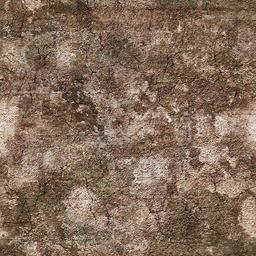

filtroBilateral(filtroBilateral(erodir(WHITE, y), max(y, y)), min(sub(y, x), x))


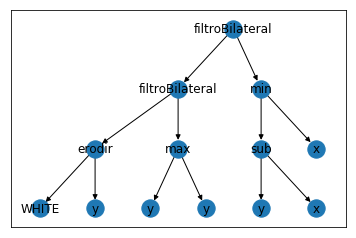

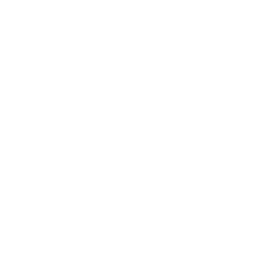

In [11]:
cv2_imshow(TARGET_IMG)

for individual in range(0, N_HALL_OF_FAME_INDIVIDUALS):
  expression = textureGenerator.getResultantExpression(individual)
  texture = textureGenerator.generateTexture(individual, 10, 124);
  
  print(expression)
  plotTree(expression)
  cv2_imshow(texture)
